## Functions for graphics in Chemical engineering paper - April 2024

In [177]:

import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import seaborn as sns
from scipy.optimize import direct
import sys
from matplotlib.lines import Line2D
from scipy.stats import multivariate_normal
# Define a dictionary to map method names to colors

method_colors = {
    'TS-Constrained_UCB': 'blue',
    'TS-Constrained_EI': 'green',
    'PC-Nested-UCB': 'red',
    'PC-Nested-GPUCB': 'cyan',
    'PC-Basic-GPUCB': 'pink',
    'PC-Basic-UCB': 'purple',
    'Random': 'orange',
    'Sequential BO UCB': 'black',
    'GP-UCB-PE': 'brown', 
    'HPC-TS-UCB': 'blue',
}

def load_pickle(file_path):
    with open(file_path, "rb") as file:
        data = pickle.load(file)
    return data

def load_gp(file):
    with open(file, 'rb') as g:
        gp = pickle.load(g)
    return gp

def load_histories(file):
    with open(file, 'rb') as f:
        history = pickle.load(f)
    return history

def calculate_log_normalized_regret(histories_dict, global_max, epsilon = 0):
    """
    Calculate the log normalized regret for each iteration given the history of observed values.
    """
    log_normalized_regrets = []

    # Process each run
    for label, histories in histories_dict.items():
        # Calculate the best result found so far at each iteration for each run
        best_results_per_run = [np.maximum.accumulate([np.max(y) for y in history]) for history in histories]
        #print(f'{label}: {best_results_per_run} \n')
        # Calculate the regret for each iteration
        regret_per_run = (global_max - np.array(best_results_per_run))/global_max
        # Calculate log normalized regret, add a small constant to avoid log(0)
        # epsilon = 1e-2
        log_normalized_regret_per_run = np.log10(regret_per_run + epsilon) #- np.log(global_max + epsilon)
        log_normalized_regrets.extend(log_normalized_regret_per_run)  # Use extend instead of append

    # Calculate mean and standard deviation of log normalized regret at each iteration across all runs
    log_normalized_regrets = np.array(log_normalized_regrets)
    mean_log_normalized_regret = np.median(log_normalized_regrets, axis=0) #<---- MEDIAN
    #mean_log_normalized_regret = np.mean(log_normalized_regrets, axis=0) #<---- MEAN    
    std_log_normalized_regret = np.std(log_normalized_regrets, axis=0)
    
    return mean_log_normalized_regret, std_log_normalized_regret, log_normalized_regrets[:, -1]


def calculate_log_normalized_regret_offset(histories_dict, global_max, offset):
    """
    Calculate the log normalized regret for each iteration given the history of observed values.

    Adds an offset to optimal estimates in case of maximum at 0: adapts to amplitude of the function, typically the global max of the positive version.
    """
    log_normalized_regrets = []

    # Process each run
    for label, histories in histories_dict.items():
        # Calculate the best result found so far at each iteration for each run
        best_results_per_run = [offset + np.maximum.accumulate([np.max(y) for y in history]) for history in histories]
        # Calculate the regret for each iteration
        regret_per_run = (global_max - np.array(best_results_per_run))
        # Calculate log normalized regret, add a small constant to avoid log(0)
        log_normalized_regret_per_run = np.log10(np.abs(regret_per_run)/global_max) #- np.log(global_max + epsilon)
        log_normalized_regrets.extend(log_normalized_regret_per_run)  # Use extend instead of append

    # Calculate mean and standard deviation of log normalized regret at each iteration across all runs
    log_normalized_regrets = np.array(log_normalized_regrets)
    mean_log_normalized_regret = np.median(log_normalized_regrets, axis=0) #<---- MEDIAN
    #mean_log_normalized_regret = np.mean(log_normalized_regrets, axis=0) #<---- MEAN
    std_log_normalized_regret = np.std(log_normalized_regrets, axis=0)
    
    return mean_log_normalized_regret, std_log_normalized_regret, log_normalized_regrets[:, -1]


def plot_log_normalized_regret(mean_log_normalized_regrets, std_log_normalized_regrets, method_names, last_iteration_regrets, filename, x_limit=75):
    """
    Plot the log normalized regret with shaded standard deviation for each method.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    first_log_regret = 0
    for mean_log_normalized_regret, std_log_normalized_regret, label in zip(mean_log_normalized_regrets, std_log_normalized_regrets, method_names):
        if label == 'Bayesian': 
            label = 'Sequential BO UCB'
        elif label == 'gp_ucb_pe':
            label = 'GP-UBC-PE'
        # elif label == 'HPC-TS-UCB':
        #     print('Im here ******')
        #     color = method_colors.get('TS-Constrained_UCB')
        # elif label == 'GP-UCB-PE':
        #     color = method_colors.get('GP-UBC-PE')
        else: 
            pass
        color = method_colors.get(label, 'gray')  # Get the color from the dictionary, default to gray if not found
        if label == 'TS-Constrained_UCB':
            print(f'{label}: I am starting here!! \n')
            first_log_regret = mean_log_normalized_regret[0]
            print(f'First log regret value: {first_log_regret} \n')
            # axes[0].plot(0, first_log_regret, 'o', markersize=12, label='Initialization')

        axes[0].plot(mean_log_normalized_regret, label=label, color=color)
        # axes[0].fill_between(range(len(mean_log_normalized_regret)), mean_log_normalized_regret - std_log_normalized_regret, mean_log_normalized_regret + std_log_normalized_regret, alpha=0.2, color=color)

    axes[0].set_xlabel('Iteration', fontsize=20)
    axes[0].set_ylabel('Log-normalized regret', fontsize=20)
    axes[0].set_xlim((0, x_limit))
    # axes[0].set_ylim((-5, 1))
    # axes[0].legend(fontsize=10)
    axes[0].grid(True)
    
    ### Set the size of the x and y ticks
    axes[0].tick_params(axis='both', which='major', labelsize=16)
    
    axes[0].plot(0, first_log_regret, 'o', markersize=11, color='orange', label='Initialization')
    
    # Plotting KDE of last iteration regrets   <---------------- KDE plot --
    for regrets, label in zip(last_iteration_regrets, method_names):
        #print(f'Hi Ich bin {label} and {np.histogram(regrets)}')
        sns.kdeplot(regrets, vertical=True, bw_adjust=0.2, ax=axes[1], label=label, color=method_colors.get(label, 'gray'), fill=True)
    
    axes[1].set_xlabel('Density', fontsize=20)
    #axes[1].set_ylabel('log-regret at last iteration', fontsize=12)
    axes[1].set_yticklabels('')
    axes[1].set_yticks([])

    # Create a custom legend entry
    custom_entry = Line2D([0], [0], marker='o', color='orange', label='Initialization', markersize=11, linestyle="None")

    # Get the existing legend entries
    handles, labels = axes[1].get_legend_handles_labels()

    # Add the custom entry to the existing entries
    handles.append(custom_entry)
    # Create the legend with the updated entries
    axes[1].legend(handles=handles, fontsize=16, loc='lower right')
    #axes[1].legend(fontsize=16, loc='lower right' )

    ### Set the size of the x ticks on the second subplot
    axes[1].tick_params(axis='x', which='major', labelsize=16)

    #    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)  

    return fig, axes
    
def helper_to_order(directory_path, desired_x_values):
    "Helper function to consistentely order files, such that order in plots is always equal"
    # Get the list of files
    files = os.listdir(directory_path)

    # Iterate over the files
    for file in files:
        # Iterate over the identifiers
        for i, identifier in enumerate(desired_x_values, start=0):
            # If the identifier is in the filename
            if identifier in file:
                # Prepend the index to the filename
                new_filename = f"{i}_{file}"
                # Rename the file
                os.rename(os.path.join(directory_path, file), os.path.join(directory_path, new_filename))

    # Get the list of files
    files = os.listdir(directory_path)
    if 'X_values' in files:
        files.remove('X_values')

    # Define a function to extract the number from the filename
    def extract_number(filename):
        return int(filename.split('_')[0])

    # Sort the files based on the number
    list_data_files = sorted(files, key=extract_number)
    return list_data_files

path_stored_figures = './../fig_new/'

# ylim0 = axes[0].get_ylim()
# print(ylim0)
# axes[1].set_ylim(ylim0)

# # Save figure & Adjust the file format and resolution
# SAVEDIR = '/Users/pchainai/TRAVAIL/COLLAB/THESES/MARKUS/ChemPAPER/Paper/fig_new/'
# plt.savefig(SAVEDIR + filename) #, dpi=300)  

# plt.show()


## Hartmann 6D with KDE / correct maximum value / using median (log-norm-regret)

TS-Constrained_UCB: I am starting here!! 

First log regret value: -0.02134011602959955 



<ipython-input-177-8d8cefc3c860>:139: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(regrets, vertical=True, bw_adjust=0.2, ax=axes[1], label=label, color=method_colors.get(label, 'gray'), fill=True)
<ipython-input-177-8d8cefc3c860>:139: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(regrets, vertical=True, bw_adjust=0.2, ax=axes[1], label=label, color=method_colors.get(label, 'gray'), fill=True)
<ipython-input-177-8d8cefc3c860>:139: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(regrets, vertical=True, bw_adjust=0.2, ax=axes[1], label=label, color=method_colors.get(label, 'gray'), fill=True)
<ipython-input-177-8d8cefc3c860>:139: UserWarning

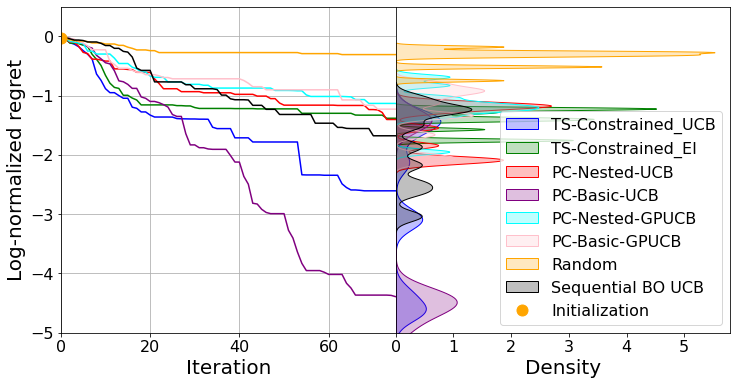

In [178]:
mean_log_normalized_regrets = []
std_log_normalized_regrets = []
method_names = []
last_regret = []
# Path to the directory where the pickled history files are stored
# directory_path = "./hartmann6d/results/"
directory_path = "./hartmann6d/results_same_initial_point/"

filename = 'hartmann6D_m4_con3'

# Known global maximum for the Hartmann 6D function
global_maximum_value = 3.32237


## Version with same intial conditions to be updated
# directory_path = "./results_same_initial_point/"

desired_x_values = ['TS-Constrained_UCB', 'TS-Constrained_EI', 'PC-Nested-UCB', 'PC-Basic-UCB','PC-Nested-GPUCB', 'PC-Basic-GPUCB', 'Random', 'Bayesian']
# desired_x_values = ['TS-Constrained_UCB']

# # Permutation of order of files to get the right order in graphics
# list_data_files = os.listdir(directory_path)
# myorder = [4, 2, 6, 1, 0, 7, 8, 5]
# list_data_files = [list_data_files[i] for i in myorder]

list_data_files = helper_to_order(directory_path, desired_x_values)

# Process each history file
for history_file in list_data_files:
    start_idx = history_file.find('experimental_')
    end_idx = history_file.find('_hartmann6d.pkl', start_idx)
    x_value = history_file[start_idx + len('experimental_'):end_idx]
    #print(x_value)
    if x_value in desired_x_values:
        if x_value == 'Bayesian':
            x_value = 'Sequential BO UCB'
        file_path = os.path.join(directory_path, history_file)
        histories_dict = load_pickle(file_path)
        
        # Calculate log normalized regret for the loaded history data
        mean_log_normalized_regret, std_log_normalized_regret, last_regret_array = calculate_log_normalized_regret(histories_dict, global_maximum_value)
        
        mean_log_normalized_regrets.append(mean_log_normalized_regret)
        std_log_normalized_regrets.append(std_log_normalized_regret)
        last_regret.append(last_regret_array)
        method_names.append(x_value)  # Extract method name from the file name
        #print(history_file)
    else: 
        print(f"Skipping '{history_file}' with X = {x_value}")
        
# Plot the log normalized regret for each method
fig, axes = plot_log_normalized_regret(mean_log_normalized_regrets, std_log_normalized_regrets, method_names, last_regret, filename)

axes[0].set_ylim(-5,0.5)

ylim0 = axes[0].get_ylim()

axes[1].set_ylim(ylim0)

# # Save figure & Adjust the file format and resolution
SAVEDIR = path_stored_figures
plt.savefig(SAVEDIR + filename) #, dpi=300)  

plt.show()


## Levy 6D - m=4, 3 contraints - same graphics

In [179]:
from scipy.optimize import direct, Bounds


# Known global maximum for the levy 6D function
# global_maximum_value = -np.min([levy_6d([-5,-5, -5, -5, -5, -5])[0], optvalue])

global_maximum_value = 47.34174044422323
print("New optvalue for comparison in log regret: ", global_maximum_value)

      
epsilon = 1e-7
offset = global_maximum_value + epsilon
print("Needs to translate all the results by ", offset)


def levy_6d(X):
    """Levy function modified to accept both 1D and 2D array input."""
    X = np.atleast_2d(X) # Ensure X is 2D for consistent numpy operations
    w = 1 + (X - 1) / 4
    term1 = np.sin(np.pi * w[:, 0]) ** 2
    term3 = (w[:, -1] - 1) ** 2 * (1 + np.sin(2 * np.pi * w[:, -1]) ** 2)
    term2 = np.sum((w[:, :-1] - 1) ** 2 * (1 + 10 * np.sin(np.pi * w[:, :-1] + 1) ** 2), axis=1)
    result = term1 + term2 + term3
    return global_maximum_value-1*result  # swapped

# Bounds for each of the 6 dimensions
bounds = Bounds([-5] * 6, [5] * 6)

# Using scipy.optimize.direct to find the minimum of the Levy function
result = direct(levy_6d, bounds, maxiter=10000, len_tol=1e-9)
optvalue = result.fun

print(optvalue)

# Print the results
# print("Optimal parameters:", result.x)
# print("Function value at optimal parameters:", result.fun)

# print(global_maximum_value + levy_6d([1,1,1,1,1,1]))

print("Value at the corner = ", levy_6d([-5,-5, -5, -5, -5, -5])[0])



New optvalue for comparison in log regret:  47.34174044422323
Needs to translate all the results by  47.34174054422323
1.6034203681190462
Value at the corner =  0.0


In [180]:
# Path to the directory where the pickled history files are stored
#directory_path = './Levy_6d_correct/results/'
directory_path = './Levy_6d_correct/results_same_initial_point/'

filename = 'levy6d_m4_con3'
fun_name = 'Levy6d'

## Version with same intial conditions to be updated
# directory_path = "./results_same_initial_point/"

desired_x_values = ['TS-Constrained_EI','TS-Constrained_UCB', 'PC-Basic-GPUCB', 'PC-Basic-UCB','PC-Nested-GPUCB', 'PC-Nested-UCB', 'Bayesian', 'Random']
#desired_x_values = ['TS-Constrained_UCB']

# # Permutation of order of files to get the right order in graphics
# list_data_files = os.listdir(directory_path)

# list_data_files
# myorder = [5, 6, 1, 3, 0, 8, 7, 4] #[4, 3, 2, 1, 0, 6, 7, 5]
# list_data_files = [list_data_files[i] for i in myorder]

list_data_files = helper_to_order(directory_path, desired_x_values)

list_data_files

['0_0_0_0_0_0_0_0_0_0_0_0_0_0_1_0_histories_dict_y_function_experimental_TS-Constrained_EI_Levy6d.pkl',
 '1_1_1_1_1_1_1_1_1_1_1_1_1_1_0_1_histories_dict_y_function_experimental_TS-Constrained_UCB_Levy6d.pkl',
 '2_2_2_2_2_2_2_2_2_2_2_2_2_2_2_2_histories_dict_y_function_experimental_PC-Basic-GPUCB_Levy6d.pkl',
 '3_3_3_3_3_3_3_3_3_3_3_3_3_3_3_3_histories_dict_y_function_experimental_PC-Basic-UCB_Levy6d.pkl',
 '4_4_4_4_4_4_4_4_4_4_4_4_4_4_4_4_histories_dict_y_function_experimental_PC-Nested-GPUCB_Levy6d.pkl',
 '5_5_5_5_5_5_5_5_5_5_5_5_5_5_5_5_histories_dict_y_function_experimental_PC-Nested-UCB_Levy6d.pkl',
 '6_6_6_6_6_6_6_6_6_6_6_6_6_6_6_6_histories_dict_y_function_experimental_Bayesian_Levy6d.pkl',
 '7_7_7_7_7_7_7_7_7_7_7_7_7_7_7_7_histories_dict_y_function_experimental_Random_Levy6d.pkl']

TS-Constrained_UCB: I am starting here!! 

First log regret value: -0.5926034178540635 

(-2.6412410813268865, -0.40718416833885934)


<ipython-input-177-8d8cefc3c860>:139: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(regrets, vertical=True, bw_adjust=0.2, ax=axes[1], label=label, color=method_colors.get(label, 'gray'), fill=True)
<ipython-input-177-8d8cefc3c860>:139: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(regrets, vertical=True, bw_adjust=0.2, ax=axes[1], label=label, color=method_colors.get(label, 'gray'), fill=True)
<ipython-input-177-8d8cefc3c860>:139: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(regrets, vertical=True, bw_adjust=0.2, ax=axes[1], label=label, color=method_colors.get(label, 'gray'), fill=True)
<ipython-input-177-8d8cefc3c860>:139: UserWarning

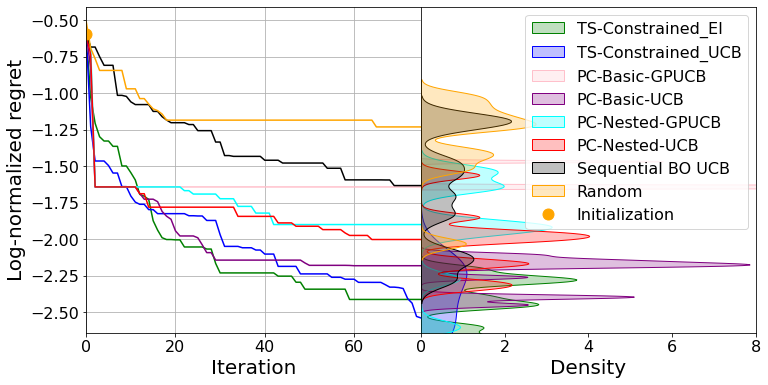

In [182]:

# Init lists
mean_log_normalized_regrets = []
std_log_normalized_regrets = []
method_names = []
last_regret = []

# Process each history file
for history_file in list_data_files:
    start_idx = history_file.find('experimental_')
    #suffix = '_'+ fun_name + '.pkl'
    end_idx = history_file.find('_'+ fun_name + '.pkl', start_idx)  # HERE CHANGE NAMES !!!
    x_value = history_file[start_idx + len('experimental_'):end_idx]
    if x_value in desired_x_values:
        if x_value == 'Bayesian':
            x_value = 'Sequential BO UCB'
        file_path = os.path.join(directory_path, history_file)
        histories_dict = load_pickle(file_path)
        
        # Calculate log normalized regret for the loaded history data
        mean_log_normalized_regret, std_log_normalized_regret, last_regret_array = calculate_log_normalized_regret_offset(histories_dict, global_maximum_value, offset)
        # with no offset use:calculate_log_normalized_regret(histories_dict, global_maximum_value)
        
        mean_log_normalized_regrets.append(mean_log_normalized_regret)
        std_log_normalized_regrets.append(std_log_normalized_regret)
        last_regret.append(last_regret_array)
        method_names.append(x_value)  # Extract method name from the file name
    else: 
        print(f"Skipping '{history_file}' with X = {x_value}")
# Plot the log normalized regret for each method
# Plot the log normalized regret for each method
fig, axes = plot_log_normalized_regret(mean_log_normalized_regrets, std_log_normalized_regrets, method_names, last_regret, filename)

#axes[0].set_ylim(-1,1.25)

ylim0 = axes[0].get_ylim()
print(ylim0)
axes[1].set_ylim(ylim0)
axes[1].set_xlim(0,8)
#axes[1].legend(fontsize=16, loc='upper right' )
# Create a custom legend entry
custom_entry = Line2D([0], [0], marker='o', color='orange', label='Initialization', markersize=11, linestyle="None")

# Get the existing legend entries
handles, labels = axes[1].get_legend_handles_labels()

# Add the custom entry to the existing entries
handles.append(custom_entry)
# Create the legend with the updated entries
axes[1].legend(handles=handles, fontsize=16, loc='upper right')

# Save figure & Adjust the file format and resolution
SAVEDIR = path_stored_figures
plt.savefig(SAVEDIR + filename) #, dpi=300)  

plt.show()

# Rosenbrock 4D number constraints 1,2 or 3 - Markus 

In [183]:
from scipy.optimize import direct, Bounds
import numpy as np


# Known global maximum for the levy 6D function
# global_maximum_value = -np.min([levy_6d([-5,-5, -5, -5, -5, -5])[0], optvalue])

# global_maximum_value = 47.34174044422323
# print("New optvalue for comparison in log regret: ", global_maximum_value)


def rosenbrock_4d_modified(X):
    """4D Rosenbrock function modified to accept both 1D and 2D array input."""
    # Ensure input is a numpy array
    X = np.asarray(X)
    
    # If 1D input, reshape to 2D
    if X.ndim == 1:
        X = X.reshape(1, -1)
    
    # Calculate Rosenbrock value for each row/sample
    values = [sum(100.0 * (x[i+1] - x[i]**2.0)**2.0 + (1 - x[i])**2.0 for i in range(3)) for x in X]
    
    return -1 * np.array(values)


# Domain is [-2.048, 2.048]^4

# Optimum is at [1, 1, 1, 1]
# print(rosenbrock_4d_modified([1, 1, 1, 1]))

# Amplitude given by the minimum value sine the maximum is 0:
print(-1*rosenbrock_4d_modified([-2., -2., -2., -2., ]))

global_maximum_value = -1*rosenbrock_4d_modified([-2., -2., -2., -2., ])

offset = global_maximum_value
print(global_maximum_value)


[10827.]
[10827.]


['0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_histories_dict_y_function_experimental_TS-Constrained_EI_1_Rosenbrock4d.pkl', '1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_histories_dict_y_function_experimental_TS-Constrained_UCB_1_Rosenbrock4d.pkl', '2_2_2_2_2_2_2_2_2_2_2_2_2_2_2_2_2_2_2_2_2_histories_dict_y_function_experimental_PC-Basic-GPUCB_1_Rosenbrock4d.pkl', '3_3_3_3_3_3_3_3_3_3_3_3_3_3_3_3_3_3_3_3_3_histories_dict_y_function_experimental_PC-Basic-UCB_1_Rosenbrock4d.pkl', '4_4_4_4_4_4_4_4_4_4_4_4_4_4_4_4_4_4_4_4_4_histories_dict_y_function_experimental_PC-Nested-GPUCB_1_Rosenbrock4d.pkl', '5_5_5_5_5_5_5_5_5_5_5_5_5_5_5_5_5_5_5_5_5_histories_dict_y_function_experimental_PC-Nested-UCB_1_Rosenbrock4d.pkl', '6_6_6_6_6_6_6_6_6_6_6_6_6_6_6_6_6_6_6_6_6_histories_dict_y_function_experimental_Bayesian_1_Rosenbrock4d.pkl', '7_7_7_7_7_7_7_7_7_7_7_7_7_7_7_7_7_7_7_7_histories_dict_y_function_experimental_Random_1_Rosenbrock4d.pkl', '8_8_8_8_7_8_8_8_8_8_8_8_8_8_8_8_8_histories_dict_y_function_exper

<ipython-input-177-8d8cefc3c860>:139: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(regrets, vertical=True, bw_adjust=0.2, ax=axes[1], label=label, color=method_colors.get(label, 'gray'), fill=True)
<ipython-input-177-8d8cefc3c860>:139: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(regrets, vertical=True, bw_adjust=0.2, ax=axes[1], label=label, color=method_colors.get(label, 'gray'), fill=True)
<ipython-input-177-8d8cefc3c860>:139: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(regrets, vertical=True, bw_adjust=0.2, ax=axes[1], label=label, color=method_colors.get(label, 'gray'), fill=True)
<ipython-input-177-8d8cefc3c860>:139: UserWarning

(-4.2395242077462525, -0.7104530077789916)
['0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_histories_dict_y_function_experimental_TS-Constrained_EI_2_Rosenbrock4d.pkl', '1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_histories_dict_y_function_experimental_TS-Constrained_UCB_2_Rosenbrock4d.pkl', '2_2_2_2_2_2_2_2_2_2_2_2_2_2_2_2_2_2_2_histories_dict_y_function_experimental_PC-Basic-GPUCB_2_Rosenbrock4d.pkl', '3_3_3_3_3_3_3_3_3_3_3_3_3_3_3_3_3_3_3_histories_dict_y_function_experimental_PC-Basic-UCB_2_Rosenbrock4d.pkl', '4_4_4_4_4_4_4_4_4_4_4_4_4_4_4_4_4_4_4_histories_dict_y_function_experimental_PC-Nested-GPUCB_2_Rosenbrock4d.pkl', '5_5_5_5_5_5_5_5_5_5_5_5_5_5_5_5_5_5_5_histories_dict_y_function_experimental_PC-Nested-UCB_2_Rosenbrock4d.pkl', '6_6_6_6_6_6_6_6_6_6_6_6_6_6_6_6_6_6_6_histories_dict_y_function_experimental_Bayesian_2_Rosenbrock4d.pkl', '7_7_7_7_7_7_7_7_7_7_7_7_7_7_7_7_7_7_7_7_histories_dict_y_function_experimental_Random_2_Rosenbrock4d.pkl', '8_8_8_8_7_8_8_8_8_8_8_8_8_8_8_8_histories_dict_y_f

<ipython-input-177-8d8cefc3c860>:139: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(regrets, vertical=True, bw_adjust=0.2, ax=axes[1], label=label, color=method_colors.get(label, 'gray'), fill=True)
<ipython-input-177-8d8cefc3c860>:139: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(regrets, vertical=True, bw_adjust=0.2, ax=axes[1], label=label, color=method_colors.get(label, 'gray'), fill=True)
<ipython-input-177-8d8cefc3c860>:139: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(regrets, vertical=True, bw_adjust=0.2, ax=axes[1], label=label, color=method_colors.get(label, 'gray'), fill=True)
<ipython-input-177-8d8cefc3c860>:139: UserWarning

(-4.314130182375237, -0.7069003423204685)
['0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_histories_dict_y_function_experimental_TS-Constrained_EI_3_Rosenbrock4d.pkl', '1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_histories_dict_y_function_experimental_TS-Constrained_UCB_3_Rosenbrock4d.pkl', '2_2_2_2_2_2_2_2_2_2_2_2_2_2_2_2_2_2_2_histories_dict_y_function_experimental_PC-Basic-GPUCB_3_Rosenbrock4d.pkl', '3_3_3_3_3_3_3_3_3_3_3_3_3_3_3_3_3_3_3_histories_dict_y_function_experimental_PC-Basic-UCB_3_Rosenbrock4d.pkl', '4_4_4_4_4_4_4_4_4_4_4_4_4_4_4_4_4_4_4_histories_dict_y_function_experimental_PC-Nested-GPUCB_3_Rosenbrock4d.pkl', '5_5_5_5_5_5_5_5_5_5_5_5_5_5_5_5_5_5_5_histories_dict_y_function_experimental_PC-Nested-UCB_3_Rosenbrock4d.pkl', '6_6_6_6_6_6_6_6_6_6_6_6_6_6_6_6_6_6_6_histories_dict_y_function_experimental_Bayesian_3_Rosenbrock4d.pkl', '7_7_7_7_7_7_7_7_7_7_7_7_7_7_7_7_7_7_7_7_histories_dict_y_function_experimental_Random_3_Rosenbrock4d.pkl', '8_8_8_8_7_8_8_8_8_8_8_8_8_8_8_8_histories_dict_y_fu

<ipython-input-177-8d8cefc3c860>:139: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(regrets, vertical=True, bw_adjust=0.2, ax=axes[1], label=label, color=method_colors.get(label, 'gray'), fill=True)
<ipython-input-177-8d8cefc3c860>:139: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(regrets, vertical=True, bw_adjust=0.2, ax=axes[1], label=label, color=method_colors.get(label, 'gray'), fill=True)
<ipython-input-177-8d8cefc3c860>:139: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(regrets, vertical=True, bw_adjust=0.2, ax=axes[1], label=label, color=method_colors.get(label, 'gray'), fill=True)
<ipython-input-177-8d8cefc3c860>:139: UserWarning

(-4.644578554311352, -0.6911647055616059)


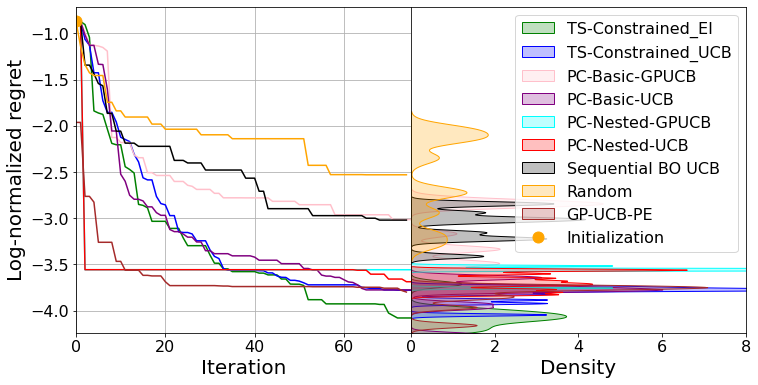

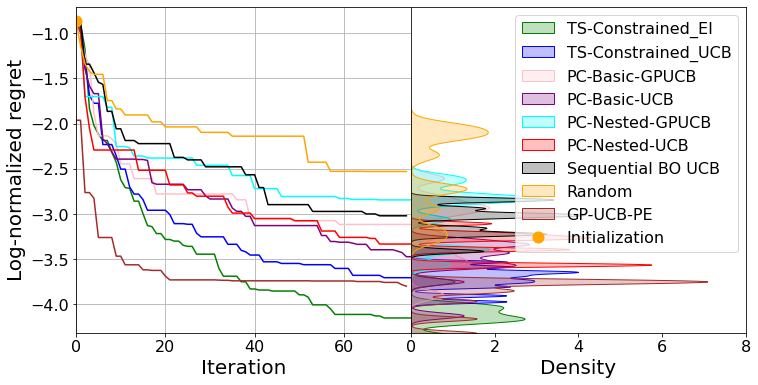

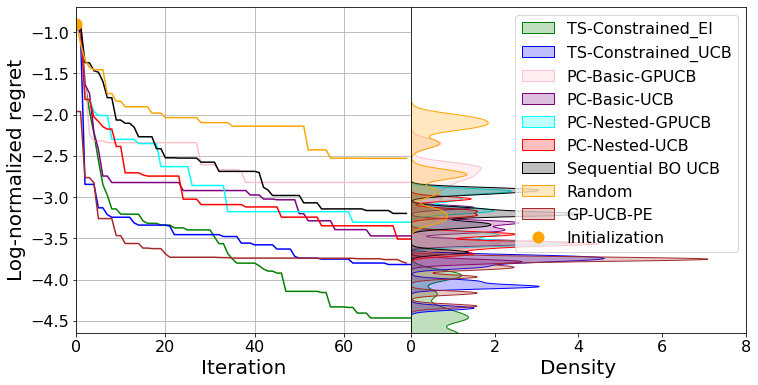

In [185]:
for num_unconstrained in range(1,4):
    directory_path = f'./rosenbrock4d_testing/results_same_initial_point/unconstrained_params_{num_unconstrained}'

    filename = f'rosenbrock4d_m4_con{4-num_unconstrained}.png'
    fun_name = 'Rosenbrock4d'

    # Define the identifiers and their order
    desired_x_values = ['TS-Constrained_EI','TS-Constrained_UCB', 'PC-Basic-GPUCB', 'PC-Basic-UCB','PC-Nested-GPUCB', 'PC-Nested-UCB', 'Bayesian', 'Random', 'gp_ucb_pe']
    #desired_x_values = ['TS-Constrained_EI','TS-Constrained_UCB', 'PC-Basic-GPUCB', 'PC-Basic-UCB','PC-Nested-GPUCB', 'PC-Nested-UCB', 'Bayesian', 'gp_ucb_pe']
    # Sort the files based on the number
    list_data_files = helper_to_order(directory_path, desired_x_values)
    print(list_data_files)

    # Init lists
    mean_log_normalized_regrets = []
    std_log_normalized_regrets = []
    method_names = []
    last_regret = []

    # Process each history file
    for history_file in list_data_files:
        start_idx = history_file.find('experimental_')
        #suffix = '_'+ fun_name + '.pkl'
        end_idx = history_file.find(f'_{num_unconstrained}'+'_'+ fun_name + '.pkl', start_idx)  # HERE CHANGE NAMES !!!
        x_value = history_file[start_idx + len('experimental_'):end_idx]
        print(x_value)
        if x_value in desired_x_values:
            if x_value == 'Bayesian':
                x_value = 'Sequential BO UCB'
            elif x_value == 'gp_ucb_pe':
                x_value = 'GP-UCB-PE'
            file_path = os.path.join(directory_path, history_file)
            histories_dict = load_pickle(file_path)
            
            # Calculate log normalized regret for the loaded history data
            mean_log_normalized_regret, std_log_normalized_regret, last_regret_array = calculate_log_normalized_regret_offset(histories_dict, global_maximum_value, offset)
            # with no offset use:calculate_log_normalized_regret(histories_dict, global_maximum_value)
            
            mean_log_normalized_regrets.append(mean_log_normalized_regret)
            std_log_normalized_regrets.append(std_log_normalized_regret)
            last_regret.append(last_regret_array)
            method_names.append(x_value)  # Extract method name from the file name
        else: 
            print(f"Skipping '{history_file}' with X = {x_value}")
    # Plot the log normalized regret for each method
    # Plot the log normalized regret for each method
    fig, axes = plot_log_normalized_regret(mean_log_normalized_regrets, std_log_normalized_regrets, method_names, last_regret, filename)

    #axes[0].set_ylim(-1,1.25)

    ylim0 = axes[0].get_ylim()
    print(ylim0)
    axes[1].set_ylim(ylim0)
    axes[1].set_xlim(0,8)
    #axes[1].legend(fontsize=16, loc='upper right' )
    # Create a custom legend entry
    custom_entry = Line2D([0], [0], marker='o', color='orange', label='Initialization', markersize=11, linestyle="None")

    # Get the existing legend entries
    handles, labels = axes[1].get_legend_handles_labels()

    # Add the custom entry to the existing entries
    handles.append(custom_entry)
    # Create the legend with the updated entries
    axes[1].legend(handles=handles, fontsize=16, loc='upper right')

    # Save figure & Adjust the file format and resolution
    SAVEDIR = path_stored_figures
    plt.savefig(SAVEDIR + filename) #, dpi=300) 

# Realistic Test Case - Flowrence

In [186]:
def maximize_gp_with_direct(gp, bounds):
    """
    Find the maximum of a Gaussian Process (GP) model using the DIRECT algorithm.
    
    :param gp: A Gaussian Process model object with a 'predict' method.
    :param bounds: Bounds for the variables as a list of (min, max) pairs.
    :param num_points: Number of points for discretizing the GP's domain for initial estimation.
    :return: The maximum value and its location.
    """
    # Define the objective function for minimization (negative of GP prediction)
    def objective_function(x, gp):
        x = np.array(x).reshape(1, -1)
        y_pred, _ = gp.predict(x, return_std=True)
        return -y_pred
    
    # Convert bounds to the required format for scipy.optimize.direct
    bounds = [(low, high) for low, high in bounds]
    
    # Perform optimization using DIRECT algorithm
    result = direct(objective_function, bounds, args=(gp,), len_tol=1e-20, eps=1e-12, maxiter=100000)
    
    # Extract the maximum value and its location
    max_location = result.x
    max_value = -result.fun
    
    return max_location, max_value 

bounds = [(0,55), (520,590)]
# Load the GP
gp = load_gp('./gpr_validation_run_standard_refined.pkl')

x_star, global_maximum_value = maximize_gp_with_direct(gp, bounds)
print(x_star, global_maximum_value)

/usr/local/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianProcessRegressor from version 0.24.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[ 33.65717281 589.99999756] 9.300243854522705


In [187]:
# Path to the directory where the pickled history files are stored
#directory_path = './Levy_6d_correct/results/'
directory_path = '../investigation_results_experimental_validation_run'

filename = 'flowrence2d_m4'
fun_name = 'Flowrence2d'

## Version with same intial conditions to be updated
# directory_path = "./results_same_initial_point/"

desired_x_values = ['TS-Constrained_EI','TS-Constrained_UCB', 'PC-Basic-GPUCB', 'PC-Basic-UCB','PC-Nested-GPUCB', 'PC-Nested-UCB', 'Skopt', 'Random']
#desired_x_values = ['TS-Constrained_UCB']

# # Permutation of order of files to get the right order in graphics
# list_data_files = os.listdir(directory_path)

# list_data_files
# myorder = [5, 6, 1, 3, 0, 8, 7, 4] #[4, 3, 2, 1, 0, 6, 7, 5]
# list_data_files = [list_data_files[i] for i in myorder]

list_data_files = helper_to_order(directory_path, desired_x_values)

list_data_files

['0_0_0_0_0_0_0_0_0_0_histories_dict_function_case_1_num_1_experimental_TS-Constrained_EI_Flowrence2d.pkl',
 '1_1_1_1_1_1_1_1_1_1_histories_dict_function_case_1_num_1_experimental_TS-Constrained_UCB_Flowrence2d.pkl',
 '2_2_2_2_2_2_2_2_2_2_histories_dict_function_case_1_num_1_experimental_PC-Basic-GPUCB_Flowrence2d.pkl',
 '3_3_3_3_3_3_3_3_3_3_histories_dict_function_case_1_num_1_experimental_PC-Basic-UCB_Flowrence2d.pkl',
 '4_4_4_4_4_4_4_4_4_4_histories_dict_function_case_1_num_1_experimental_PC-Nested-GPUCB_Flowrence2d.pkl',
 '5_5_5_5_5_5_5_5_5_5_histories_dict_function_case_1_num_1_experimental_PC-Nested-UCB_Flowrence2d.pkl',
 '6_6_6_6_6_6_6_6_6_6_histories_dict_function_case_1_num_1_experimental_Skopt_Flowrence2d.pkl',
 '7_7_7_7_7_7_7_7_7_7_histories_dict_function_case_1_num_1_experimental_Random_Flowrence2d.pkl']

TS-Constrained_UCB: I am starting here!! 

First log regret value: -0.2935012027872508 

(-6.909278903442193, 0.08946367883217732)


<ipython-input-177-8d8cefc3c860>:139: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(regrets, vertical=True, bw_adjust=0.2, ax=axes[1], label=label, color=method_colors.get(label, 'gray'), fill=True)
<ipython-input-177-8d8cefc3c860>:139: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(regrets, vertical=True, bw_adjust=0.2, ax=axes[1], label=label, color=method_colors.get(label, 'gray'), fill=True)
<ipython-input-177-8d8cefc3c860>:139: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(regrets, vertical=True, bw_adjust=0.2, ax=axes[1], label=label, color=method_colors.get(label, 'gray'), fill=True)
<ipython-input-177-8d8cefc3c860>:139: UserWarning

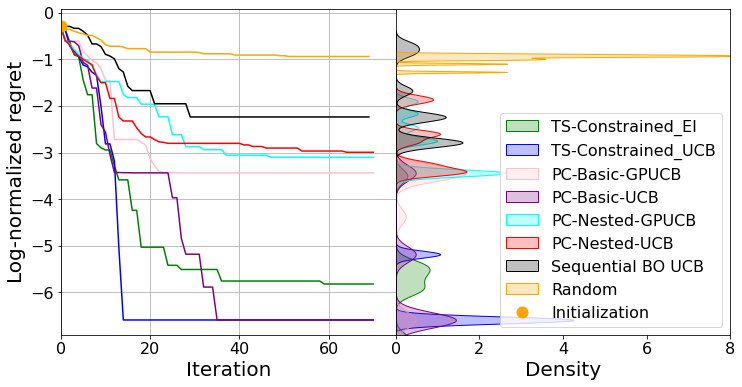

In [188]:

# Init lists
mean_log_normalized_regrets = []
std_log_normalized_regrets = []
method_names = []
last_regret = []

# Process each history file
for history_file in list_data_files:
    start_idx = history_file.find('experimental_')
    #suffix = '_'+ fun_name + '.pkl'
    end_idx = history_file.find('_'+ fun_name + '.pkl', start_idx)  # HERE CHANGE NAMES !!!
    x_value = history_file[start_idx + len('experimental_'):end_idx]
    if x_value in desired_x_values:
        if x_value == 'Skopt':
            x_value = 'Sequential BO UCB'
        file_path = os.path.join(directory_path, history_file)
        histories_dict = load_pickle(file_path)
        # Calculate log normalized regret for the loaded history data
        mean_log_normalized_regret, std_log_normalized_regret, last_regret_array = calculate_log_normalized_regret(histories_dict, global_maximum_value)
        # with no offset use:calculate_log_normalized_regret(histories_dict, global_maximum_value)
        # print(f'{x_value}: {last_regret_array}\n')
        mean_log_normalized_regrets.append(mean_log_normalized_regret)
        std_log_normalized_regrets.append(std_log_normalized_regret)
        last_regret.append(last_regret_array)
        method_names.append(x_value)  # Extract method name from the file name
    else: 
        print(f"Skipping '{history_file}' with X = {x_value}")
# Plot the log normalized regret for each method
# Plot the log normalized regret for each method
fig, axes = plot_log_normalized_regret(mean_log_normalized_regrets, std_log_normalized_regrets, method_names, last_regret, filename)

#axes[0].set_ylim(-1,1.25)

ylim0 = axes[0].get_ylim()
print(ylim0)
axes[1].set_ylim(ylim0)
axes[1].set_xlim(0,8)
#axes[1].legend(fontsize=16, loc='center right' )
# Create a custom legend entry
custom_entry = Line2D([0], [0], marker='o', color='orange', label='Initialization', markersize=11, linestyle="None")

# Get the existing legend entries
handles, labels = axes[1].get_legend_handles_labels()

# Add the custom entry to the existing entries
handles.append(custom_entry)
# Create the legend with the updated entries
axes[1].legend(handles=handles, fontsize=16, loc='lower right')

# Save figure & Adjust the file format and resolution
SAVEDIR = path_stored_figures
plt.savefig(SAVEDIR + filename) #, dpi=300)  

plt.show()

# Hierarchical Process Constraint (HPC) Rosenbrock 3D results

In [189]:
def rosenbrock_3d(x, a=1, b=100):
    """
    Computes the Rosenbrock function in 3 dimensions.
    The function is generally defined by:
        f(x, y, z) = (a-x1)^2 + b*(x2-x1^2)^2 + (a-x2)^2 + b*(x3-x2^2)^2
    where typically a = 1 and b = 100.

    Parameters:
    - x : array_like, The input variables array where x = [x1, x2, x3].
    - a : float, The constant term for the (a-x)^2 part (default: 1).
    - b : float, The constant term for the b*(y-x^2)^2 part (default: 100).

    Returns:
    - float, The Rosenbrock function evaluated at the point x.
    """
    X = np.atleast_2d(x)  # Ensure X is 2D
    
    # Calculate the Rosenbrock function for each row in X (each input vector)
    sum_terms = (a - X[:, 0])**2 + b * (X[:, 1] - X[:, 0]**2)**2 + (a - X[:, 1])**2 + b * (X[:, 2] - X[:, 1]**2)**2
    return - sum_terms

In [190]:
# Domain is [-2.048, 2.048]^4

# Optimum is at [1, 1, 1, 1]
# print(rosenbrock_4d_modified([1, 1, 1, 1]))

# Amplitude given by the minimum value sine the maximum is 0:
print(-1* rosenbrock_3d([-2., -2., -2., -2.]))

global_maximum_value = -1* rosenbrock_3d([-2., -2., -2., -2.])

offset = global_maximum_value
print(global_maximum_value)

[7218.]
[7218.]


In [191]:
# Path to the directory where the pickled history files are stored
#directory_path = './Levy_6d_correct/results/'
directory_path = './rosenbrock3d_hpc/results_same_initial_point/'

filename = 'rosenbrock3d_m2_m4'
fun_name = 'Rosenbrock3d'

## Version with same intial conditions to be updated
# directory_path = "./results_same_initial_point/"

desired_x_values = ['TS-Constrained_EI', 'PC-Basic-UCB', 'HPC-TS','GP-UCB-PE', 'BOopt']

list_data_files = helper_to_order(directory_path, desired_x_values)

list_data_files

['2_2_2_2_2_2_0_0_0_0_0_0_0_0_0_histories_dict_y_function_experimental_HPC-TS_Rosenbrock3d.pkl',
 '3_3_3_3_3_3_1_1_1_1_1_1_1_1_1_histories_dict_y_function_experimental_GP-UCB-PE_Rosenbrock3d.pkl']

Hi Ich bin HPC-TS-UCB and (array([1, 0, 3, 3, 3, 4, 0, 0, 0, 1]), array([-5.70496715, -5.2362123 , -4.76745745, -4.29870261, -3.82994776,
       -3.36119291, -2.89243806, -2.42368322, -1.95492837, -1.48617352,
       -1.01741868]))
Hi Ich bin GP-UCB-PE and (array([1, 0, 0, 1, 3, 1, 1, 0, 5, 3]), array([-7.43385694, -7.04349774, -6.65313854, -6.26277934, -5.87242014,
       -5.48206094, -5.09170174, -4.70134254, -4.31098334, -3.92062414,
       -3.53026494]))
(-4.4289701127347465, -1.6082946686332287)


<ipython-input-28-2a597da87bc2>:131: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(regrets, vertical=True, bw_adjust=0.2, ax=axes[1], label=label, color=method_colors.get(label, 'gray'), fill=True)
<ipython-input-28-2a597da87bc2>:131: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(regrets, vertical=True, bw_adjust=0.2, ax=axes[1], label=label, color=method_colors.get(label, 'gray'), fill=True)


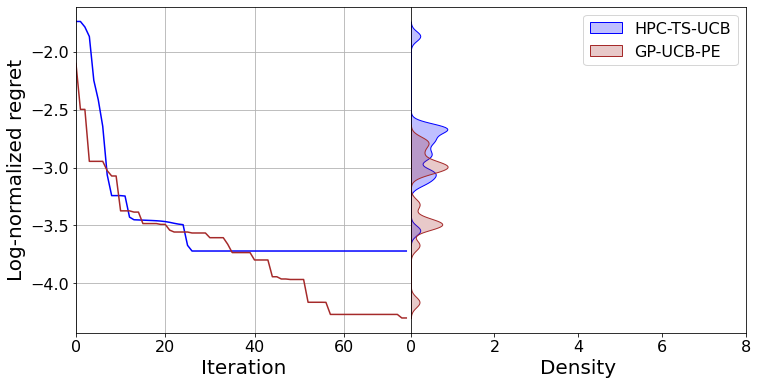

In [43]:

# Init lists
mean_log_normalized_regrets = []
std_log_normalized_regrets = []
method_names = []
last_regret = []

# Process each history file
for history_file in list_data_files:
    start_idx = history_file.find('experimental_')
    #suffix = '_'+ fun_name + '.pkl'
    end_idx = history_file.find('_'+ fun_name + '.pkl', start_idx)  # HERE CHANGE NAMES !!!
    x_value = history_file[start_idx + len('experimental_'):end_idx]
    if x_value in desired_x_values:
        if x_value == 'HPC-TS':
            x_value = 'HPC-TS-UCB'
        elif x_value == 'BOopt':
            x_value = 'Sequential BO UCB'
        file_path = os.path.join(directory_path, history_file)
        histories_dict = load_pickle(file_path)
        
        # Calculate log normalized regret for the loaded history data
        mean_log_normalized_regret, std_log_normalized_regret, last_regret_array = calculate_log_normalized_regret_offset(histories_dict, global_maximum_value, offset)
        # with no offset use:calculate_log_normalized_regret(histories_dict, global_maximum_value)
        
        mean_log_normalized_regrets.append(mean_log_normalized_regret)
        std_log_normalized_regrets.append(std_log_normalized_regret)
        last_regret.append(last_regret_array)
        method_names.append(x_value)  # Extract method name from the file name
    else: 
        print(f"Skipping '{history_file}' with X = {x_value}")
# Plot the log normalized regret for each method
# Plot the log normalized regret for each method
fig, axes = plot_log_normalized_regret(mean_log_normalized_regrets, std_log_normalized_regrets, method_names, last_regret, filename)

#axes[0].set_ylim(-1,1.25)

ylim0 = axes[0].get_ylim()
print(ylim0)
#axes[1].set_ylim(ylim0)
axes[1].set_xlim(0,8)
axes[1].legend(fontsize=16, loc='upper right' )

# Save figure & Adjust the file format and resolution
SAVEDIR = path_stored_figures
plt.savefig(SAVEDIR + filename) #, dpi=300)  

plt.show()

# GMM's with KDE's


# GMM's Assesment


In [192]:
#experiment.py file 
class GaussianMixtureModel:
    def __init__(self, filename):
        with open(filename, "rb") as file:
            data = pickle.load(file)
        self.n_components = data.n_components
        self.means = data.means
        self.covariances = data.covariances
        self.weights = data.weights

    def pdf(self, x):
        # Calculate the PDF of the GMM at x
        pdf = np.sum([self.weights[k] * multivariate_normal.pdf(x, self.means[k], self.covariances[k]) for k in range(self.n_components)], axis=0)
        return pdf
    
def maximize_gp_with_direct(gp, bounds):
    """
    Find the maximum of a Gaussian Process (GP) model using the DIRECT algorithm.
    
    :param gp: A Gaussian Process model object with a 'predict' method.
    :param bounds: Bounds for the variables as a list of (min, max) pairs.
    :param num_points: Number of points for discretizing the GP's domain for initial estimation.
    :return: The maximum value and its location.
    """
    
    def objective_function(X, gmm):
        """Objective function for GMM that accepts a 2D numpy array"""
        return -1 * np.array([gmm.pdf(X)])

    # Convert bounds to the required format for scipy.optimize.direct
    bounds = [(low, high) for low, high in bounds]
    
    # Perform optimization using DIRECT algorithm
    result = direct(objective_function, bounds, args=(gp,), len_tol=1e-20, eps=1e-12, maxiter=100000)
    
    # Extract the maximum value and its location
    max_location = result.x
    max_value = -result.fun
    
    return max_location, max_value 


## Combined Analysis2

TS-Constrained_UCB
TS-Constrained_EI
PC-Nested-UCB
PC-Basic-UCB
PC-Nested-GPUCB
PC-Basic-GPUCB
Random
Bayesian
Skipping '7_histories_dict_y_function_experimental_Bayesian_gmm_case_1.pkl' with X = Bayesian
BO_opt
TS-Constrained_UCB: I am starting here!! 

First log regret value: -0.016270578990711115 



<ipython-input-177-8d8cefc3c860>:139: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(regrets, vertical=True, bw_adjust=0.2, ax=axes[1], label=label, color=method_colors.get(label, 'gray'), fill=True)
<ipython-input-177-8d8cefc3c860>:139: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(regrets, vertical=True, bw_adjust=0.2, ax=axes[1], label=label, color=method_colors.get(label, 'gray'), fill=True)
<ipython-input-177-8d8cefc3c860>:139: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(regrets, vertical=True, bw_adjust=0.2, ax=axes[1], label=label, color=method_colors.get(label, 'gray'), fill=True)
<ipython-input-177-8d8cefc3c860>:139: UserWarning

(-6.465997460285063, 0.3002316369440591)


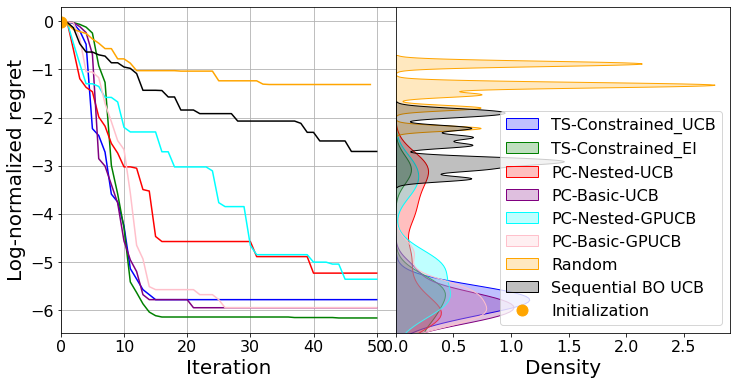

TS-Constrained_UCB
TS-Constrained_EI
PC-Nested-UCB
PC-Basic-UCB
PC-Nested-GPUCB
PC-Basic-GPUCB
Random
Bayesian
Skipping '7_histories_dict_y_function_experimental_Bayesian_gmm_case_1.pkl' with X = Bayesian
BO_opt
TS-Constrained_UCB: I am starting here!! 

First log regret value: -0.05262361005918015 



<ipython-input-177-8d8cefc3c860>:139: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(regrets, vertical=True, bw_adjust=0.2, ax=axes[1], label=label, color=method_colors.get(label, 'gray'), fill=True)
<ipython-input-177-8d8cefc3c860>:139: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(regrets, vertical=True, bw_adjust=0.2, ax=axes[1], label=label, color=method_colors.get(label, 'gray'), fill=True)
<ipython-input-177-8d8cefc3c860>:139: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(regrets, vertical=True, bw_adjust=0.2, ax=axes[1], label=label, color=method_colors.get(label, 'gray'), fill=True)
<ipython-input-177-8d8cefc3c860>:139: UserWarning

(-6.714600195676921, 0.2646133702083313)


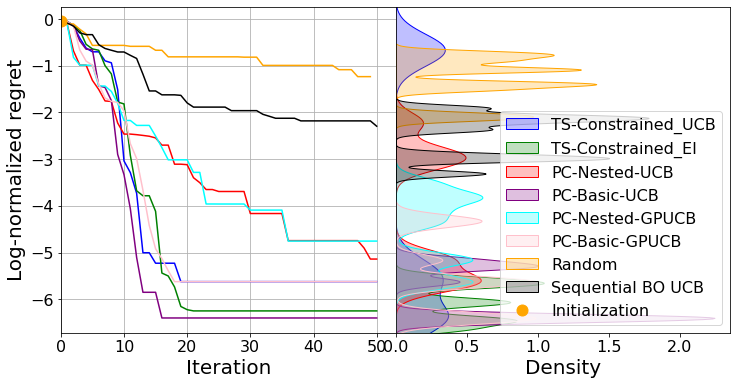

TS-Constrained_UCB
TS-Constrained_EI
PC-Nested-UCB
PC-Basic-UCB
PC-Nested-GPUCB
PC-Basic-GPUCB
Random
Bayesian
Skipping '7_histories_dict_y_function_experimental_Bayesian_gmm_case_1.pkl' with X = Bayesian
BO_opt
TS-Constrained_UCB: I am starting here!! 

First log regret value: -0.17775529226389356 

(-7.3159127003478694, 0.31953846020902965)


<ipython-input-177-8d8cefc3c860>:139: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(regrets, vertical=True, bw_adjust=0.2, ax=axes[1], label=label, color=method_colors.get(label, 'gray'), fill=True)
<ipython-input-177-8d8cefc3c860>:139: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(regrets, vertical=True, bw_adjust=0.2, ax=axes[1], label=label, color=method_colors.get(label, 'gray'), fill=True)
<ipython-input-177-8d8cefc3c860>:139: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(regrets, vertical=True, bw_adjust=0.2, ax=axes[1], label=label, color=method_colors.get(label, 'gray'), fill=True)
<ipython-input-177-8d8cefc3c860>:139: UserWarning

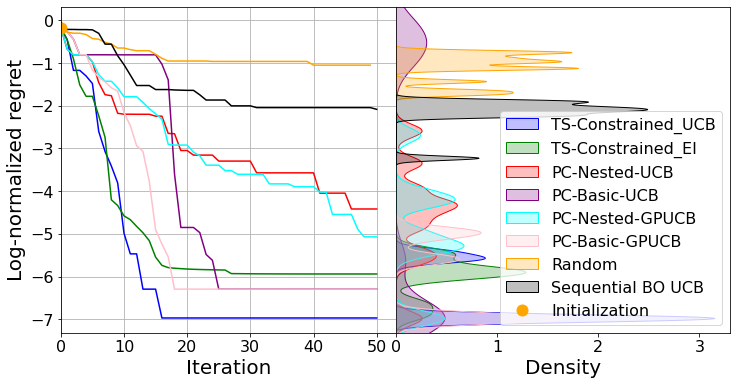

TS-Constrained_UCB
TS-Constrained_EI
PC-Nested-UCB
PC-Basic-UCB
PC-Nested-GPUCB
PC-Basic-GPUCB
Random
Bayesian
Skipping '7_histories_dict_y_function_experimental_Bayesian_gmm_case_1.pkl' with X = Bayesian
BO_opt
TS-Constrained_UCB: I am starting here!! 

First log regret value: -0.24393965416224406 



<ipython-input-177-8d8cefc3c860>:139: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(regrets, vertical=True, bw_adjust=0.2, ax=axes[1], label=label, color=method_colors.get(label, 'gray'), fill=True)
<ipython-input-177-8d8cefc3c860>:139: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(regrets, vertical=True, bw_adjust=0.2, ax=axes[1], label=label, color=method_colors.get(label, 'gray'), fill=True)
<ipython-input-177-8d8cefc3c860>:139: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(regrets, vertical=True, bw_adjust=0.2, ax=axes[1], label=label, color=method_colors.get(label, 'gray'), fill=True)
<ipython-input-177-8d8cefc3c860>:139: UserWarning

(-6.833941467333893, 0.11690268404205492)


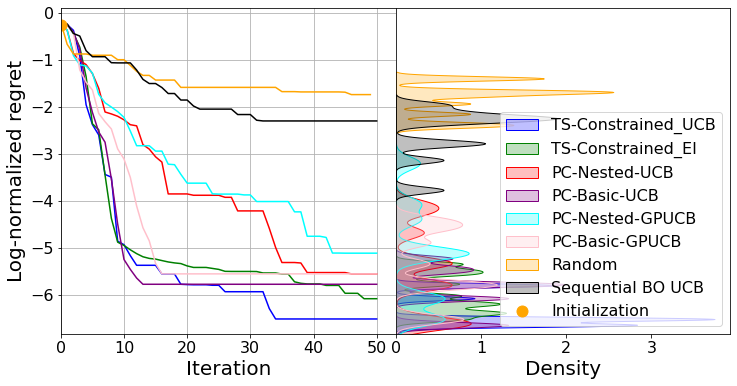

In [193]:
for i in range(1,5):


    directory_path_gmm = f'./pickled_gmms_paper/gmm_case_{i}_num_1.pkl'
    # Create the GMM
    gmm = GaussianMixtureModel(directory_path_gmm)

    bounds = [(-3,3), (-3,3)]
    # Load the GP

    x_star, global_maximum_value = maximize_gp_with_direct(gmm, bounds)

    directory_path = f'../investigation_results_gmm_case_{i}/'
    filename = f'gmm_case_{i}_2d_m4'
    fun_name = 'gmm_case_1'

    ## Version with same intial conditions to be updated
    # directory_path = "./results_same_initial_point/"

    desired_x_values = ['TS-Constrained_UCB', 'TS-Constrained_EI', 'PC-Nested-UCB', 'PC-Basic-UCB','PC-Nested-GPUCB', 'PC-Basic-GPUCB', 'Random', 'BO_opt']
    # desired_x_values = ['TS-Constrained_UCB']
    
    mean_log_normalized_regrets = []
    std_log_normalized_regrets = []
    method_names = []
    last_regret = []

    list_data_files = helper_to_order(directory_path, desired_x_values)

    # Process each history file
    for history_file in list_data_files:
        start_idx = history_file.find('experimental_')
        end_idx = history_file.find('_'+ fun_name + '.pkl', start_idx) 
        x_value = history_file[start_idx + len('experimental_'):end_idx]
        print(x_value)
        if x_value in desired_x_values:
            if x_value == 'BO_opt':
                x_value = 'Sequential BO UCB'
            file_path = os.path.join(directory_path, history_file)
            histories_dict = load_pickle(file_path)
            
            # Calculate log normalized regret for the loaded history data
            mean_log_normalized_regret, std_log_normalized_regret, last_regret_array = calculate_log_normalized_regret(histories_dict, global_maximum_value, epsilon=1e-12)
            #mean_log_normalized_regret, std_log_normalized_regret, last_regret_array = calculate_log_normalized_regret(histories_dict, global_maximum_value)
            
            mean_log_normalized_regrets.append(mean_log_normalized_regret)
            std_log_normalized_regrets.append(std_log_normalized_regret)
            last_regret.append(last_regret_array)
            method_names.append(x_value)  # Extract method name from the file name
            #print(history_file)
        else: 
            print(f"Skipping '{history_file}' with X = {x_value}")
            
    # Plot the log normalized regret for each method
    fig, axes = plot_log_normalized_regret(mean_log_normalized_regrets, std_log_normalized_regrets, method_names, last_regret, filename, x_limit=53)

    #axes[0].set_ylim(-5,0.5)

    ylim0 = axes[0].get_ylim()
    print(ylim0)
    axes[1].set_ylim(ylim0)

    # Save figure & Adjust the file format and resolution
    SAVEDIR = path_stored_figures
    plt.savefig(SAVEDIR + filename) #, dpi=300)  

    plt.show()
     

In [130]:
import numpy as np
from scipy.optimize import direct, differential_evolution
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from scipy.optimize import Bounds
from scipy.stats import norm

class BayesianOptimization:
    def __init__(self, bounds, func, initial_points=None, state_seed =None, kernel=None, alpha=1e-10, kappa=2.576, xi=0.01):
        self.bounds = np.array(bounds)
        self.func = func
        self.xi=xi
        self.kappa = kappa
        self.state_seed=state_seed
        self.gpr = GaussianProcessRegressor(kernel=kernel if kernel else Matern(), alpha=alpha, n_restarts_optimizer=10, normalize_y=True)
        

        # Normalize initial points or generate a random initial point
        if initial_points is None:
            normalized_x = self._normalize(np.array([self._random_sample()]))
            self.X = normalized_x
            self.y = np.array([func(self._denormalize(normalized_x)[0])])
        else:
            self.X = self._normalize(np.array(initial_points))
            self.y = np.array([func(self._denormalize(x)) for x in initial_points])

        self.gpr.fit(self.X, self.y)

    def _random_sample(self):
        np.random.seed=self.state_seed
        return np.array([np.random.uniform(low, high) for low, high in self.bounds])

    def _normalize(self, X):

        # Normalize X to [0, 1]
        return (X - self.bounds[:, 0]) / (self.bounds[:, 1] - self.bounds[:, 0])

    def _denormalize(self, X):
        # Rescale X back to the original bounds
        return X * (self.bounds[:, 1] - self.bounds[:, 0]) + self.bounds[:, 0]

    def _ucb(self, x, *args):
        x = np.atleast_2d(x)
        mean, std = self.gpr.predict(x, return_std=True)
        return -(mean - self.kappa * std)[0]  # Minus for minimization in scipy.optimize.direct

    def _expected_improvement(self, x):
        """Calculate the expected improvement at point x."""
        x = np.atleast_2d(x)
        mean, std = self.gpr.predict(x, return_std=True)
        if std == 0:
            return 0
        else:
            improvement = mean - self.y.max() - self.xi
            Z = improvement / std
            ei = improvement * norm.cdf(Z) + std * norm.pdf(Z)
            return -ei  # Minimize negative EI for maximization problem

    
    def optimize(self, n_iter=10, eps=1e-4, maxfun=None, maxiter=1000):
        for _ in range(n_iter):
            res = direct(self._expected_improvement, Bounds([0]*len(self.bounds), [1]*len(self.bounds)),
                         eps=eps, maxfun=maxfun, maxiter=maxiter, locally_biased=True)

            if res.success:
                new_x = res.x
            else:
                # Fallback to differential evolution if DIRECT fails
                res = differential_evolution(self._expected_improvement, bounds=self.bounds)
                print("DIRECT failed; used Differential Evolution instead.")
                new_x = res.x
            # else:
            #     # Sample a random point in normalized space if optimization was not successful
            #     new_x = self._normalize(np.array([self._random_sample()]))[0]
            #     print("Optimization was not successful; sampled a random point instead.")

            new_y = self.func(new_x)

            # Update the model with new data point in normalized space
            self.X = np.vstack([self.X, new_x])
            self.y = np.append(self.y, new_y)
            self.gpr.fit(self.X, self.y)

    def best_point(self):
        idx_best = np.argmax(self.y)
        return self.X[idx_best], self.y[idx_best]

    def get_observations(self):
        return self.y

    def get_X(self):
        return self.X




In [123]:
directory_path_gmm = f'./pickled_gmms_paper/gmm_case_2_num_1.pkl'
# Create the GMM
gmm = GaussianMixtureModel(directory_path_gmm)

bounds = [(-3,3), (-3,3)]
# Load the GP

x_star, global_maximum_value = maximize_gp_with_direct(gmm, bounds)
x_star, global_maximum_value

(array([-0.38412584, -2.8441981 ]), 0.11345605771679988)

In [137]:
def gmm_objective_function_array(X):
    """Objective function for GMM that accepts a 2D numpy array"""
    return np.array([gmm.pdf(X)])
bounds = [(-3, 3), (-3, 3)]
bo = BayesianOptimization(bounds, gmm_objective_function_array)
bo.optimize(n_iter=50)
print("Best point:", bo.best_point())

DIRECT failed; used Differential Evolution instead.
DIRECT failed; used Differential Evolution instead.
DIRECT failed; used Differential Evolution instead.
DIRECT failed; used Differential Evolution instead.
DIRECT failed; used Differential Evolution instead.
DIRECT failed; used Differential Evolution instead.
DIRECT failed; used Differential Evolution instead.
DIRECT failed; used Differential Evolution instead.
DIRECT failed; used Differential Evolution instead.
DIRECT failed; used Differential Evolution instead.
DIRECT failed; used Differential Evolution instead.
DIRECT failed; used Differential Evolution instead.
DIRECT failed; used Differential Evolution instead.
DIRECT failed; used Differential Evolution instead.
DIRECT failed; used Differential Evolution instead.
DIRECT failed; used Differential Evolution instead.
DIRECT failed; used Differential Evolution instead.
DIRECT failed; used Differential Evolution instead.
DIRECT failed; used Differential Evolution instead.
DIRECT faile